Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset loaded, sample data:
                                             content sentiment
0  Wants to know how the hell I can remember word...     happy
1  Love is a long sweet dream & marriage is an al...     happy
2  The world could be amazing when you are slight...     happy
3  My secret talent is getting tired without doin...     happy
4  Khatarnaak Whatsapp Status Ever… Can\’t talk, ...     happy
Training Original Mini-GPT...
Epoch 0, Loss 4.7958
Epoch 50, Loss 2.7355
Epoch 100, Loss 2.4031
Epoch 150, Loss 2.5451
Epoch 200, Loss 2.1944
Epoch 250, Loss 2.4465
Epoch 300, Loss 2.2090
Epoch 350, Loss 2.1811
Epoch 400, Loss 2.2104
Epoch 450, Loss 2.2038
Epoch 500, Loss 2.3409
Epoch 550, Loss 2.2983
Epoch 600, Loss 2.2825
Epoch 650, Loss 2.1644
Epoch 700, Loss 2.1267
Epoch 750, Loss 2.0318
Epoch 800, Loss 2.0076
Epoch 850, Loss 2.1450
Epoch 900, Loss 2.0817


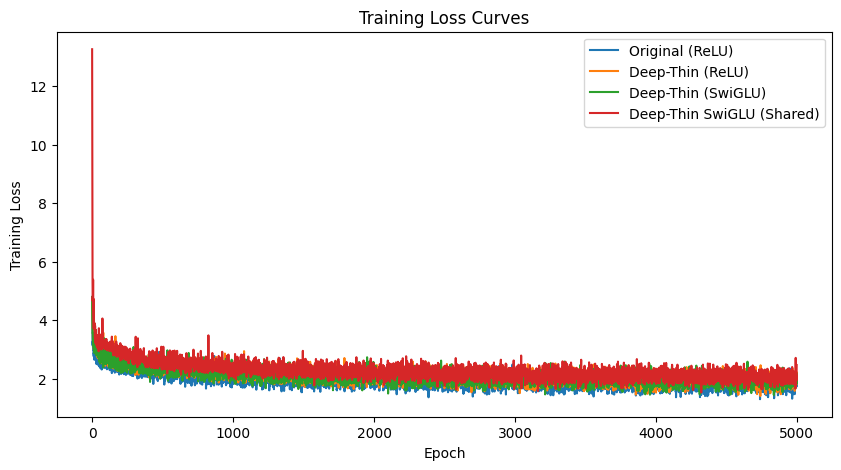

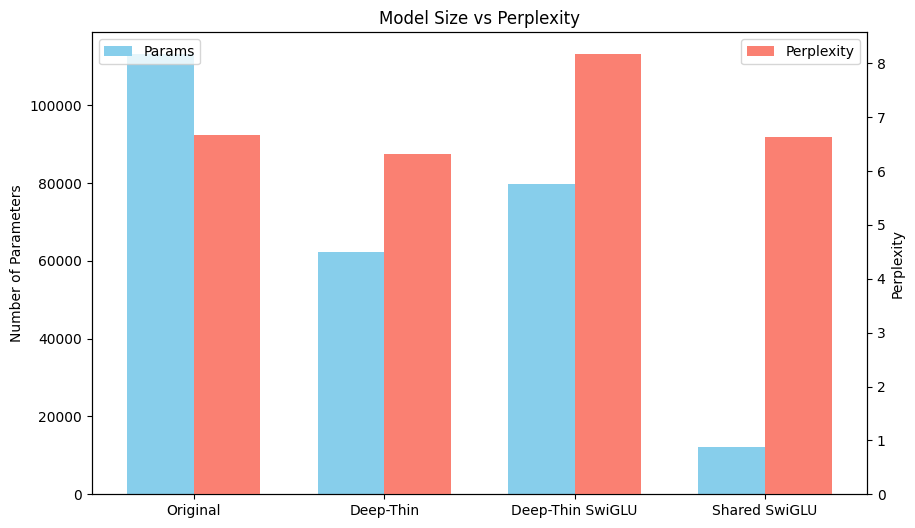


Generated by Original Mini-GPT:
 Happy be Nevery withtake bresper you and, the, you by Sy just a her way. Wineops you aborg happers is ages

Generated by Deep-and-Thin GPT:
 Happy chublot. Ise to jeed is a so dodon't lovle realles hutt youy hat. Soughing sat inelap, likes o us fu

Generated by Deep-and-Thin GPT (SwiGLU):
 Happy cattues ting th anthy if you chearly oniest onld sovery. . Ther oly. You, onch luthou chere peionsh 

Generated by Deep-and-Thin SwiGLU (Shared):
 Happy onesss yally you'ret the ker you bentt it of the outh ae stelyT. A themsinge innd wanke feey fucble 


In [ ]:
# ================================
# Compare Mini-GPT variants with Shared Embedding and Layer Sharing
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------
# 1️⃣ Set seeds
# ------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------
# 1️⃣ Mount Google Drive
# ------------------
from google.colab import drive
drive.mount('/content/drive')

# ------------------
# 2️⃣ Load the dataset
# ------------------
import pandas as pd

# Replace with the full path to your CSV on Drive
csv_path = "/content/drive/My Drive/Colab Notebooks/MinIGPT/Emotion(happy).csv"

df = pd.read_csv(csv_path)
print("Dataset loaded, sample data:")
print(df.head())

# Use the 'content' column as text data
texts = df['content'].astype(str).tolist()
full_text = " ".join(texts)

chars = sorted(list(set(full_text)))
vocab_size = len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for i,c in enumerate(stoi)}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return "".join([itos[i] for i in l])

data = torch.tensor(encode(full_text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ------------------
# 3️⃣ Data loader
# ------------------
def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# ------------------
# 4️⃣ Transformer building blocks
# ------------------
class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embedding_dim, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# SwiGLU Implementation
# ------------------
class SwiGLU(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.w1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.v = nn.Linear(hidden_dim, input_dim, bias=False)

    def forward(self, x):
        return self.v(self.w1(x) * torch.sigmoid(self.w2(x)))

class FeedForwardSwiGLU(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        hidden_dim = embedding_dim * 4
        self.net = nn.Sequential(
            SwiGLU(embedding_dim, hidden_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class BlockSwiGLU(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForwardSwiGLU(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# 5️⃣ GPT Classes
# ------------------
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

class MiniGPTSwiGLU(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.blocks = nn.Sequential(*[
            BlockSwiGLU(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)
        ])

# ------------------
# 6️⃣ Deep-and-Thin SwiGLU with Embedding & Layer Sharing
# ------------------
class MiniGPTSwiGLU_Shared(MiniGPT):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__(vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout)
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        shared_block = BlockSwiGLU(embedding_dim, n_heads, dropout, block_size)
        self.blocks = nn.ModuleList([shared_block for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size, bias=False)
        self.lm_head.weight = self.token_embedding_table.weight
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        for block in self.blocks:
            x = block(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

# ------------------
# 7️⃣ Training helper
# ------------------
def train_model(model_class, config, train_data, val_data, epochs=200):
    model = model_class(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        block_size=config['block_size'],
        dropout=config['dropout']
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    train_losses = []
    for epoch in range(epochs):
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")
    # Validation
    xb, yb = get_batch(val_data, config['batch_size'], config['block_size'])
    with torch.no_grad():
        _, val_loss = model(xb, yb)
    perplexity = torch.exp(val_loss).item()
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, train_losses, val_loss.item(), perplexity, param_count

# ------------------
# 8️⃣ Configs
# ------------------
block_size = 16
dropout = 0.1
batch_size = 8
lr = 1e-2
epochs = 5000

original_config = {
    'embedding_dim': 64,
    'n_layers': 2,
    'n_heads': 4,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

deepthin_config = {
    'embedding_dim': 24,
    'n_layers': 8,
    'n_heads': 2,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# ------------------
# 9️⃣ Train models
# ------------------
print("Training Original Mini-GPT...")
orig_model, orig_losses, orig_val_loss, orig_ppl, orig_params = train_model(MiniGPT, original_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT...")
deep_model, deep_losses, deep_val_loss, deep_ppl, deep_params = train_model(MiniGPT, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT (SwiGLU)...")
deep_swiglu_model, deep_swiglu_losses, deep_swiglu_val_loss, deep_swiglu_ppl, deep_swiglu_params = train_model(MiniGPTSwiGLU, deepthin_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin SwiGLU (Shared)...")
shared_model, shared_losses, shared_val_loss, shared_ppl, shared_params = train_model(MiniGPTSwiGLU_Shared, deepthin_config, train_data, val_data, epochs)

# ------------------
# 10️⃣ Compare metrics
# ------------------
print("\n===== Comparison =====")
print(f"Original Mini-GPT: Val Loss={orig_val_loss:.4f}, Perplexity={orig_ppl:.4f}, Params={orig_params}")
print(f"Deep-and-Thin GPT: Val Loss={deep_val_loss:.4f}, Perplexity={deep_ppl:.4f}, Params={deep_params}")
print(f"Deep-and-Thin GPT (SwiGLU): Val Loss={deep_swiglu_val_loss:.4f}, Perplexity={deep_swiglu_ppl:.4f}, Params={deep_swiglu_params}")
print(f"Deep-and-Thin SwiGLU (Shared): Val Loss={shared_val_loss:.4f}, Perplexity={shared_ppl:.4f}, Params={shared_params}")

# ------------------
# 11️⃣ Plot training curves
# ------------------
plt.figure(figsize=(10,5))
plt.plot(orig_losses, label='Original (ReLU)')
plt.plot(deep_losses, label='Deep-Thin (ReLU)')
plt.plot(deep_swiglu_losses, label='Deep-Thin (SwiGLU)')
plt.plot(shared_losses, label='Deep-Thin SwiGLU (Shared)')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

# ------------------
# 12️⃣ Bar chart: Model Size vs Perplexity
# ------------------
models = ['Original', 'Deep-Thin', 'Deep-Thin SwiGLU', 'Shared SwiGLU']
params = [orig_params, deep_params, deep_swiglu_params, shared_params]
ppls = [orig_ppl, deep_ppl, deep_swiglu_ppl, shared_ppl]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(x - width/2, params, width, color='skyblue', label='Params')
ax1.set_ylabel('Number of Parameters')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_title('Model Size vs Perplexity')

ax2 = ax1.twinx()
ax2.bar(x + width/2, ppls, width, color='salmon', label='Perplexity')
ax2.set_ylabel('Perplexity')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# ------------------
# 13️⃣ Generate story continuation
# ------------------
prompt = "Happy "
context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

gen_orig = orig_model.generate(context, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context, max_new_tokens=100)[0].tolist()
gen_swiglu = deep_swiglu_model.generate(context, max_new_tokens=100)[0].tolist()
gen_shared = shared_model.generate(context, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode(gen_orig))
print("\nGenerated by Deep-and-Thin GPT:\n", decode(gen_deep))
print("\nGenerated by Deep-and-Thin GPT (SwiGLU):\n", decode(gen_swiglu))
print("\nGenerated by Deep-and-Thin SwiGLU (Shared):\n", decode(gen_shared))


After running the cell above, please re-run the original code cell to download the dataset.